# MVA - Homework 1 - Reinforcement Learning (2022/2023)

**Name:** DELLIAUX Thomas

## Instructions

* The deadline is **November 10 at 11:59 pm (Paris time).**

* By doing this homework you agree to the late day policy, collaboration and misconduct rules reported on [Piazza](https://piazza.com/class/l4y5ubadwj64mb/post/6).

* **Mysterious or unsupported answers will not receive full credit**. A correct answer, unsupported by calculations, explanation, or algebraic work will receive no credit; an incorrect answer supported by substantially correct calculations and explanations might still receive partial credit.

* Answers should be provided in **English**.

# Colab setup

In [ ]:
from IPython import get_ipython

if 'google.colab' in str(get_ipython()):
  # install rlberry library
  !pip install git+https://github.com/rlberry-py/rlberry.git@mva2021#egg=rlberry[default] > /dev/null 2>&1

  # install ffmpeg-python for saving videos
  !pip install ffmpeg-python > /dev/null 2>&1

  # packages required to show video
  !pip install pyvirtualdisplay > /dev/null 2>&1
  !apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

  print("Libraries installed, please restart the runtime!")


Libraries installed, please restart the runtime!


In [ ]:
# Create directory for saving videos
!mkdir videos > /dev/null 2>&1

# Initialize display and import function to show videos
import rlberry.colab_utils.display_setup
from rlberry.colab_utils.display_setup import show_video

In [ ]:
# Useful libraries
import numpy as np
import matplotlib.pyplot as plt

# Preparation

In the coding exercises, you will use a *grid-world* MDP, which is represented in Python using the interface provided by the [Gym](https://gym.openai.com/) library. The cells below show how to interact with this MDP and how to visualize it.


In [ ]:
from rlberry.envs import GridWorld

def get_env():
  """Creates an instance of a grid-world MDP."""
  env = GridWorld(
      nrows=5,
      ncols=7,
      reward_at = {(0, 6):1.0},
      walls=((0, 4),(1, 4), (2, 4), (3, 4)),
      success_probability=0.9,
      terminal_states=((0, 6),)
  )
  return env

def render_policy(env, policy=None, horizon=50):
  """Visualize a policy in an environment

  Args:
    env: GridWorld
        environment where to run the policy
    policy: np.array
        matrix mapping states to action (Ns).
        If None, runs random policy.
    horizon: int
        maximum number of timesteps in the environment.
  """
  env.enable_rendering()
  state = env.reset()                       # get initial state
  for timestep in range(horizon):
      if policy is None:
        action = env.action_space.sample()  # take random actions
      else:
        action = policy[state]
      next_state, reward, is_terminal, info = env.step(action)
      state = next_state
      if is_terminal:
        break
  # save video and clear buffer
  env.save_video('./videos/gw.mp4', framerate=5)
  env.clear_render_buffer()
  env.disable_rendering()
  # show video
  show_video('./videos/gw.mp4')


In [ ]:
# Create an environment and visualize it
env = get_env()
render_policy(env)  # visualize random policy

# The reward function and transition probabilities can be accessed through
# the R and P attributes:
print(f"Shape of the reward array = (S, A) = {env.R.shape}")
print(f"Shape of the transition array = (S, A, S) = {env.P.shape}")
print(f"Reward at (s, a) = (1, 0): {env.R[1, 0]}")
print(f"Prob[s\'=2 | s=1, a=0]: {env.P[1, 0, 2]}")
print(f"Number of states and actions: {env.Ns}, {env.Na}")

# The states in the griworld correspond to (row, col) coordinates.
# The environment provides a mapping between (row, col) and the index of
# each state:
print(f"Index of state (1, 0): {env.coord2index[(1, 0)]}")
print(f"Coordinates of state 5: {env.index2coord[5]}")

Shape of the reward array = (S, A) = (31, 4)
Shape of the transition array = (S, A, S) = (31, 4, 31)
Reward at (s, a) = (1, 0): 0.0
Prob[s'=2 | s=1, a=0]: 0.04999999999999999
Number of states and actions: 31, 4
Index of state (1, 0): 6
Coordinates of state 5: (0, 6)


# Part 1 - Dynamic Programming

## Question 1.1

Consider a general MDP with a discount factor of $\gamma < 1$. Assume that the horizon is infinite (so there is no termination). A policy $\pi$ in this MDP
induces a value function $V^\pi$. Suppose an affine transformation is applied to the reward, what is
the new value function? Is the optimal policy preserved?



### **Answer**

Let define $r'(s,a)= wr(s,a)+b$, where $w,b\in R$.Let $s\in S$ we have : 
$$\begin{equation}
\begin{split}
V'(s) &=\mathbb{E}[\sum_{t=0}^{+\infty}\gamma^tr'(s_t,a_t)]\\
&=\mathbb{E}[\sum_{t=0}^{+\infty}\gamma^t(wr(s_t,a_t)+b)]\\
&=w\mathbb{E}[\sum_{t=0}^{+\infty}\gamma^tr(s_t,a_t))]+b\sum_{t=0}^{+\infty}\gamma^t\\
&=w\times V(s)+\frac{b}{1-\gamma}
\end{split}
\end{equation}$$
Hence $V'(s)=wV(s)+\frac{b}{1-\gamma},\forall s \in S$.
Now let's see if the optimal policy is preserved.
If $w>0$, let $s \in S$, we have : 
$$V^{'*}(s)=\max_\pi V^{'\pi}(s)=\max_\pi wV^\pi(s)+\frac{b}{1-\gamma}=w(\max_\pi V^\pi(s))+\frac{b}{1-\gamma}$$, so $\pi \mapsto V^{' \pi}(s)$ reaches its maximum in $\pi^*$. The optimal policy is preserved.

If w=0, let $s \in S$, we have :
$$V^{'\pi}(s)=0.V^\pi(s)+\frac{b}{1-\gamma}=\frac{b}{1-\gamma}$$, so $\pi \mapsto V^{' \pi}(s)$ reaches its maximum, $\frac{b}{1-\gamma}$, for any policies since it is constant. The optimal policy is not preserved.

If w<0, let $s \in S$, we have : 

$$V^{'*}(s)=\max_\pi V^{'\pi}(s)=\max_\pi wV^\pi(s)+\frac{b}{1-\gamma}=w(\min_\pi V^\pi(s))+\frac{b}{1-\gamma}$$, so we optimal policy is not preserved since $\pi \mapsto V^{'\pi}(s)$ reaches its maximum when  $\pi \mapsto V^{\pi}(s)$ reaches its minimum. $\pi^*$ can't be a solution of $\max_\pi V^{'\pi}(s)$.


## Question 1.2

Consider an infinite-horizon $\gamma$-discounted MDP. We denote by $Q^*$ the $Q$-function of the optimal policy $\pi^*$. Prove that, for any function $Q(s, a)$ (which is **not** necessarily the value function of a policy), the following inequality holds for any state $s$:

$$
V^{\pi_Q}(s) \geq V^*(s) - \frac{2}{1-\gamma}||Q^*-Q||_\infty,
$$

where $||Q^*-Q||_\infty = \max_{s, a} |Q^*(s, a) - Q(s, a)|$ and $\pi_Q(s) \in \arg\max_a Q(s, a)$. Can you use this result to show that any policy $\pi$ such that $\pi(s) \in \arg\max_a Q^*(s, a)$ is optimal?

### **Answer**

Let $s∈S$, we have :
$$
\begin{equation}
\begin{split}
2\left\|Q^*-Q\right\|_{\infty}&\geq \left|Q^*(s,\pi ^*(s))-Q(s,\pi^*(s))\right| + \left|Q(s,\pi_Q(s))-Q^*(s,\pi_Q(s))\right|\\
&\geq Q^*(s,\pi ^*(s))-Q(s,\pi^*(s))+Q(s,\pi_Q(s))-Q^*(s,\pi_Q(s))\\
&\geq Q^*(s,\pi ^*(s))-Q(s,\pi_Q(s))+Q(s,\pi_Q(s))-Q^*(s,\pi_Q(s))=Q^*(s,\pi ^*(s))-Q^*(s,\pi_Q(s))\\
&\text{ since }Q(s,\pi^*(s))\leq Q(s,\pi_Q(s))\text{ by definition of } \pi_Q \\
\end{split}
\end{equation}\\
$$
Moreove, we have :
$$
\begin{equation}
\begin{split}
2\left\|Q^*-Q\right\|_{\infty}&\geq Q^*(s,\pi ^*(s))-Q^*(s,\pi_Q(s))\\
&=Q^*(s,\pi ^*(s))-Q^{\pi_Q}(s,\pi_Q(s))+Q^{\pi_Q}(s,\pi_Q(s))-Q^*(s,\pi_Q(s))\\
&=V^*(s)-V^{\pi_Q}(s)+r(s,\pi_Q(s))+\gamma\sum_{s'}\mathbb{P}(s'|s,\pi_Q(s))V^{\pi_Q}(s')-r(s,\pi_Q(s))-\gamma\sum_{s'}\mathbb{P}(s'|s,\pi_Q(s))V^{*}(s')\\
&=V^*(s)-V^{\pi_Q}(s)-\gamma\sum_{s'}\mathbb{P}(s'|s,\pi_Q(s))(V^*(s')-V^{\pi_Q}(s'))
\end{split}
\end{equation}\\
$$
Let's definie $s^*=argmax_{s'}V^*(s')-V^{\pi_Q}(s')$. We have :
$$
\begin{equation}
\begin{split}
2\left\|Q^*-Q\right\|_{\infty}&\geq V^*(s^*)-V^{\pi_Q}(s^*)-\gamma\sum_{s'}\mathbb{P}(s'|s,\pi_Q(s))(V^*(s^*)-V^{\pi_Q}(s^*))\\
&=(1-\gamma)( V^*(s^*)-V^{\pi_Q}(s^*))\text{ since }\sum_{s'}\mathbb{P}(s'|s,\pi_Q(s))=1\\
&\geq(1-\gamma)( V^*(s)-V^{\pi_Q}(s))\text{ for all }s \in S \text{ by definition of }s^*\text{ and } 1-\gamma\geq0
\end{split}
\end{equation}\\
$$
We can deduce from that :
$$
V^{\pi_Q}(s)\geq V^*(s)-\frac{2}{1-\gamma}\left\|Q^*-Q\right\|_{\infty}
$$
We can use this result to show that any policy $\pi(s) \in \arg\max_a Q^*(s, a)$ is optimal. Indeed, if we replace in our inequality Q by Q* and $\pi_Q$ by $\pi$, we obtain : 
$V^{\pi}(s)\geq V^*(s) \forall s\in S$. Since V* is the maximum over all the policy we have $V^{\pi}=V^*$, and so $\pi$ is an optimal policy. 

## Question 1.3

In this question, you will implement and compare the policy and value iteration algorithms for a finite MDP. 

Complete the functions `policy_evaluation`, `policy_iteration` and `value_iteration` below.


Compare value iteration and policy iteration. Highlight pros and cons of each method.

### **Answer**

[pros/cons of each method + implementation below]

The advantage of policy iteration is that we have an dynamic stop condition, that is, we know that the algorithm has converged when $V_{k+1}=V_k$. While for the value iteration we use $K=\left \lceil \frac{\frac{log(1-\gamma)\epsilon}{rmax}}{log(\gamma)}  \right \rceil$ to ensure to have the same level of precision, $\epsilon>0$, for the both algorithms. But we may make to many iterations, as we can see on the graph which plot the convergence over the iteration of the value iteration algorithm. So we policy iteration is likely to converge in less iterations. 

But the cost of each iterations is greater for the policy iteration.Indeed, for each iteration we have evaluate the last policy found, and after the compute the new policy with the new value function. While with the value iteration, we just update the Q-function.

So to summerize :

-The policy iteration is likely to converge in less iterations but the cost of each iteration is greater, since we have to evaluate the policy at each iteration.


-The value iteration is likely ton converge in more iterations but the cost of each iteration is lower, since we juste compute Q.

In [ ]:
def policy_evaluation(P, R, policy, gamma=0.9, tol=1e-2):
    """
    Args:
        P: np.array
            transition matrix (NsxNaxNs)
        R: np.array
            reward matrix (NsxNa)
        policy: np.array
            matrix mapping states to action (Ns)
        gamma: float
            discount factor
        tol: float
            precision of the solution
    Return:
        value_function: np.array
            The value function of the given policy
    """
    Ns, Na = R.shape
    # ====================================================
	  # YOUR IMPLEMENTATION HERE 
    
    #I define value_function_prev to evaluate when to stop the iterations.
    value_function_prev=np.ones(Ns)
    value_function = np.zeros(Ns)
    #If we want  value_function at a distance tol of our true fixe point, according to the
    #fixe point theorem, we need to have np.linalg.norm(value_function-value_function_prev,ord=np.inf)<=tol*(1-gamma).
    while np.linalg.norm(value_function-value_function_prev,ord=np.inf)>tol*(1-gamma):
      value_function_prev=value_function.copy()

      #Update the value_function by applying the bellman operator.
      for s in range(Ns):
        value_function[s]=R[s,policy[s]]+gamma*np.dot(P[s,policy[s]],value_function)
    # ====================================================
    return value_function

In [ ]:
def policy_iteration(P, R, gamma=0.9, tol=1e-3):
    """
    Args:
        P: np.array
            transition matrix (NsxNaxNs)
        R: np.array
            reward matrix (NsxNa)
        gamma: float
            discount factor
        tol: float
            precision of the solution
    Return:
        policy: np.array
            the final policy
        V: np.array
            the value function associated to the final policy
    """
    Ns, Na = R.shape
    V_prev=np.ones(Ns)
    V = np.zeros(Ns)
    policy = np.ones(Ns, dtype=int)   
    # ====================================================
	  # YOUR IMPLEMENTATION HERE 
    #

    #Perfom the udpate until we get the desired accuracy.
    while np.linalg.norm(V-V_prev,ord=np.inf)>tol:
      V_prev = V.copy()
      #Compute the value function associated with the current policy.
      V = policy_evaluation(P,R,policy,gamma,tol)
      for s in range(Ns):
        #Compute the greedy policy.
        policy[s] = np.argmax(R[s,:]+gamma*np.dot(P[s,:],V))

    # ====================================================
    return policy, V

In [ ]:
def value_iteration(P, R, gamma=0.9, tol=1e-3):
    """
    Args:
        P: np.array
            transition matrix (NsxNaxNs)
        R: np.array
            reward matrix (NsxNa)
        gamma: float
            discount factor
        tol: float
            precision of the solution
    Return:
        Q: final Q-function (at iteration n)
        greedy_policy: greedy policy wrt Qn
        Qfs: all Q-functions generated by the algorithm (for visualization)
    """
    Ns, Na = R.shape
    Q = np.zeros((Ns, Na))
    Qfs = [Q.copy()]
    # ====================================================
	  # YOUR IMPLEMENTATION HERE 
    #
    rmax=np.max(R)
    
    K = int(np.ceil(np.log(((1-gamma)*tol)/rmax)/np.log(gamma)))
    
    for _ in range(K):
      for a in range(Na):
        for s in range(Ns):
          Q[s,a]=R[s,a]+gamma*np.dot(P[s,a],np.max(Q,axis=1))
      Qfs.append(Q.copy())
    
    greedy_policy = np.argmax(Q, axis=1)
    # ====================================================
    return Q, greedy_policy, Qfs

### Testing your code

[VI]Greedy policy: 



[PI]final policy: 


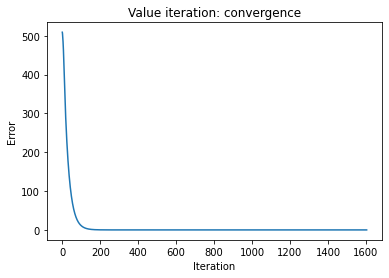

In [ ]:
# Parameters
tol = 1e-5
gamma = 0.99

# Environment
env = get_env()

# run value iteration to obtain Q-values
VI_Q, VI_greedypol, all_qfunctions = value_iteration(env.P, env.R, gamma=gamma, tol=tol)

# render the policy
print("[VI]Greedy policy: ")
render_policy(env, VI_greedypol)

# compute the value function of the greedy policy using matrix inversion
# ====================================================
# YOUR IMPLEMENTATION HERE 
# compute value function of the greedy policy
#
Ns=env.R.shape[0]
Na=env.Na
P_greedypol = np.zeros((Ns,Ns))
R_greedypol = np.zeros(Ns)
#Compute R and  P for he greedy_policy
for s in range(Ns):
  a = VI_greedypol[s]
  R_greedypol[s]=env.R[s,a]
  P_greedypol[s,:]=env.P[s,a,:]
#Apply the course formula to compute greedy_V by inversion.
greedy_V = np.linalg.inv(np.eye(Ns)-gamma*P_greedypol)@R_greedypol

# ====================================================

# show the error between the computed V-functions and the final V-function
# (that should be the optimal one, if correctly implemented)
# as a function of time
final_V = all_qfunctions[-1].max(axis=1)
norms = [ np.linalg.norm(q.max(axis=1) - final_V) for q in all_qfunctions]
plt.plot(norms)
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.title("Value iteration: convergence")

#### POLICY ITERATION ####
PI_policy, PI_V = policy_iteration(env.P, env.R, gamma=gamma, tol=tol)
print("\n[PI]final policy: ")
render_policy(env, PI_policy)

## Uncomment below to check that everything is correct
assert np.allclose(PI_policy, VI_greedypol),\
     "You should check the code, the greedy policy computed by VI is not equal to the solution of PI"
assert np.allclose(PI_V, greedy_V),\
     "Since the policies are equal, even the value function should be"

plt.show()

# Part 2 - Tabular RL

## Question 2.1

The code below collects two datasets of transitions (containing states, actions, rewards and next states) for a discrete MDP.

For each of the datasets:

1. Estimate the transitions and rewards, $\hat{P}$ and $\hat{R}$.
2. Compute the optimal value function and the optimal policy with respect to the estimated MDP (defined by $\hat{P}$ and $\hat{R}$), which we denote by $\hat{\pi}$ and $\hat{V}$.
3. Numerically compare the performance of $\hat{\pi}$ and $\pi^\star$ (the true optimal policy), and the error between $\hat{V}$ and $V^*$ (the true optimal value function).

Which of the two data collection methods do you think is better? Why?

### **Answer**

[answer last question + implementation below]

I think that the method use in get_uniform_dataset is better, because we can see by comparing the values functions that the value function obtained by the policy iteration on P_unif and R_unif is much closer to the V* than value function obtained by the policy iteration on P_rand and R_rand.

We can explain that by the fact that by taking a random policy, because we start always at the same state, we lack of exploration. Indeed, due to the walls, we tend to get stuck all time in the same area. We need to be very lucky to get a random policy which allows us to bypass the wall. While with uniform sampling, we pick a random state and we take an action. We have more chance to visit all the states, because we don't need to have the right behavior to bypass the walls. 

In [ ]:
def get_random_policy_dataset(env, n_samples):
  """Get a dataset following a random policy to collect data."""
  states = []
  actions = []
  rewards = []
  next_states = []
  
  state = env.reset()
  for _ in range(n_samples):
    action = env.action_space.sample()
    next_state, reward, is_terminal, info = env.step(action)
    states.append(state)
    actions.append(action)
    rewards.append(reward)
    next_states.append(next_state)
    # update state
    state = next_state
    if is_terminal:
      state = env.reset()

  dataset = (states, actions, rewards, next_states)
  return dataset

def get_uniform_dataset(env, n_samples):
  """Get a dataset by uniformly sampling states and actions."""
  states = []
  actions = []
  rewards = []
  next_states = []
  for _ in range(n_samples):
    state = env.observation_space.sample()
    action = env.action_space.sample()
    next_state, reward, is_terminal, info = env.sample(state, action)
    states.append(state)
    actions.append(action)
    rewards.append(reward)
    next_states.append(next_state)

  dataset = (states, actions, rewards, next_states)
  return dataset


# Collect two different datasets
num_samples = 500
env = get_env()
dataset_1 = get_random_policy_dataset(env, num_samples)
dataset_2 = get_uniform_dataset(env, num_samples)


# Item 3: Estimate the MDP with the two datasets; compare the optimal value
# functions in the true and in the estimated MDPs
P_rand = np.zeros((31,4,31))
R_rand = np.zeros((31,4))
N_rand = np.zeros((31,4,31))
rand_states, rand_actions, rand_rewards, rand_next_states = dataset_1

P_unif = np.zeros((31,4,31))
R_unif = np.zeros((31,4))
N_unif = np.zeros((31,4,31))
unif_states, unif_actions, unif_rewards, unif_next_states = dataset_2

#Compute the number of occurence of each transition in the dataset.
for i in range(num_samples):
  N_rand[rand_states[i],rand_actions[i],rand_next_states[i]]+=1
  N_unif[unif_states[i],unif_actions[i],unif_next_states[i]]+=1

#Compute some estimate of P and R for the two data sets.
for s in range(Ns):
  for a in range(Na):
    N_s_a_rand = np.sum(N_rand[s,a])
    N_s_a_unif = np.sum(N_unif[s,a])

    for i in range(num_samples):
      s_i_rand = rand_states[i]
      a_i_rand = rand_actions[i]
      r_i_rand = rand_rewards[i]

      s_i_unif = unif_states[i]
      a_i_unif = unif_actions[i]
      r_i_unif = unif_rewards[i]

      if(s == s_i_rand and a == a_i_rand):
        R_rand[s,a] += r_i_rand/N_s_a_rand
      if(s == s_i_unif and a == a_i_unif):
        R_unif[s,a] += r_i_unif/N_s_a_unif
    for s_p in range(Ns):
      if(N_s_a_rand != 0):
         P_rand[s,a,s_p] = N_rand[s,a,s_p]/N_s_a_rand
      if(N_s_a_unif != 0):
        P_unif[s,a,s_p] = N_unif[s,a,s_p]/N_s_a_unif
      



Pi_rand, V_rand = policy_iteration(P_rand,R_rand,gamma,tol)
Pi_unif, V_unif = policy_iteration(P_unif,R_unif,gamma,tol)

error_rand = np.linalg.norm(V_rand-PI_V,ord=np.inf)
error_unif = np.linalg.norm(V_unif-PI_V,ord=np.inf)

In [ ]:
print("[PI]Policy for random policy sample")
render_policy(env, Pi_rand)
print("[PI]Policy for uniform sample")
render_policy(env, Pi_unif)
print("[PI]pi *")
render_policy(env,PI_policy)
print(f"The error(norm inf) between V_rand and V* for the random sample is  = {error_rand}")
print(f"The error(norm inf) for the uniform sample is = {error_unif}")

[PI]Policy for random policy sample


[PI]Policy for uniform sample


[PI]pi *


The error(norm inf) between V_rand and V* for the random sample is  = 99.99999012613159
The error(norm inf) for the uniform sample is = 1.9175487212765887


## Question 2.2

Suppose that $\hat{P}$ and $\hat{R}$ are estimated from a dataset of exactly $N$ i.i.d. samples from **each** state-action pair. This means that, for each $(s,a)$, we have $N$ samples $\{(s_1',r_1, \dots, s_N', r_N\}$, where $s_i' \sim P(\cdot | s,a)$ and $r_i \sim R(s,a)$ for $i=1,\dots,N$, and
$$ \hat{P}(s'|s,a) = \frac{1}{N}\sum_{i=1}^N \mathbb{1}(s_i' = s'), $$
$$ \hat{R}(s,a) = \frac{1}{N}\sum_{i=1}^N r_i.$$
Suppose that $R$ is a distribution with support in $[0,1]$. Let $\hat{V}$ be the optimal value function computed in the empirical MDP (i.e., the one with transitions $\hat{P}$ and rewards $\hat{R}$). For any $\delta\in(0,1)$, derive an upper bound to the error

$$ \| \hat{V} - V^* \|_\infty $$

which holds with probability at least $1-\delta$.

**Note** Your bound should only depend on deterministic quantities like $N$, $\gamma$, $\delta$, $S$, $A$. It should *not* dependent on the actual random samples.

**Hint** The following two inequalities may be helpful.

1. **A (simplified) lemma**. For any state $\bar{s}$,

$$ |\hat{V}(\bar{s}) - V^*(\bar{s})| \leq \frac{1}{1-\gamma}\max_{s,a} \left| R(s,a) - \hat{R}(s,a) + \gamma \sum_{s'}(P(s'|s,a) - \hat{P}(s'|s,a)) V^*(s') \right|$$

2. **Hoeffding's inequality**. Let $X_1, \dots X_N$ be $N$ i.i.d. random variables bounded in the interval $[0,b]$ for some $b>0$. Let $\bar{X} = \frac{1}{N}\sum_{i=1}^N X_i$ be the empirical mean. Then, for any $\epsilon > 0$,

$$ \mathbb{P}(|\bar{X} - \mathbb{E}[\bar{X}]| > \epsilon) \leq 2e^{-\frac{2N\epsilon^2}{b^2}}.$$

### **Answer**

Let's define $X_i(s,a) = r_i+\gamma \sum_{s'}1(s_i'=s')V^*(s')$ for $(s,a) \in S\times A$, so we have $\bar X = \hat R(s,a)+\sum_{s'}\hat P(s'|s,a)V^*(s')$.

Let's note that $r_i+\gamma \sum_{s'}1(s_i'=s')V^*(s')\leq 1+\frac{\gamma}{1-\gamma}$ and $\mathbb{E}[\bar X]=R(s,a)+\sum_{s'}P(s'|s,a)V^*(s')$. Indeed, for $(s,a)$ we have :
$$
\begin{equation}
\begin{split}
\mathbb{E}[\bar X]&=\mathbb{E}[\hat R(s,a)]+\gamma\sum_{s'}V^*(s)\mathbb{E}[\hat P(s'|s,a)]\\
&=\frac{1}{N}\sum_{i=1}^N\mathbb{E}[r_i]+\gamma\sum_{s'}V^*(s)\frac{1}{N}\sum_{i=1}^N\mathbb{E}[1(s_i'=s')]\\
&=\mathbb{E}[r_1]+\gamma\sum_{s'}V^*(s)\mathbb{E}[1(s_1'=s')] \text{ because } (r_i)_i \text{ and } (s'_i)_i \text{ are i.i.d.}\\
&=R(s,a)+\gamma\sum_{s'}V^*(s)P(s'|s,a)
\end{split}
\end{equation}
$$
We can try to apply Hoeffding's inequality at $\frac{1}{1-\gamma}\max_{s,a}\left|R(s,a)-\hat R(s,a)+\gamma \sum_{s'}(P(s'|s,a)-\hat P(s'|s,a))V^*(s')\right|$, since if we find an upper bound who holds with probability at lest $1-\delta$ for this term, this upper bound hold for $\left\|\hat V-V^*\right\|_{\infty}$ with probability at lest $1-\delta$.

We have :
$$
\begin{equation}
\begin{split}
&\mathbb{P}(\frac{1}{1-\gamma}\max_{s,a}\left|R(s,a)-\hat R(s,a)+\gamma \sum_{s'}(P(s'|s,a)-\hat P(s'|s,a))V^*(s')\right|\leq\epsilon)\\
&\leftrightarrow\mathbb{P}(\max_{s,a}\left|R(s,a)-\hat R(s,a)+\gamma \sum_{s'}(P(s'|s,a)-\hat P(s'|s,a))V^*(s')\right|\leq (1-\gamma)\epsilon)\\
&\leftrightarrow\Pi_{s,a}\mathbb{P}(\left|R(s,a)-\hat R(s,a)+\gamma \sum_{s'}(P(s'|s,a)-\hat P(s'|s,a))V^*(s')\right|\leq (1-\gamma)\epsilon)\\
&\leftrightarrow\Pi_{s,a}(1-\mathbb{P}(\left|R(s,a)-\hat R(s,a)+\gamma \sum_{s'}(P(s'|s,a)-\hat P(s'|s,a))V^*(s')\right|> (1-\gamma)\epsilon))
\end{split}
\end{equation}
$$
So in order to have $\Pi_{s,a}(1-\mathbb{P}(\left|R(s,a)-\hat R(s,a)+\gamma \sum_{s'}(P(s'|s,a)-\hat P(s'|s,a))V^*(s')\right|> (1-\gamma)\epsilon))\geq 1-\delta$ we want for all $(s,a),\mathbb{P}(\left|R(s,a)-\hat R(s,a)+\gamma \sum_{s'}(P(s'|s,a)-\hat P(s'|s,a))V^*(s')\right|>(1-\gamma)\epsilon)\leq 1-(1-\delta)^{\frac{1}{|S||A|}}$.

Let's apply hoeffding, we get : $\mathbb{P}(\left|R(s,a)-\hat R(s,a)+\gamma \sum_{s'}(P(s'|s,a)-\hat P(s'|s,a))V^*(s')\right|>(1-\gamma)\epsilon)\leq2e^{\frac{-2N(1-\gamma)^2\epsilon^2}{(1+\frac{\gamma}{1-\gamma})^2}}$

Let's determine $\epsilon$ :
$$
\begin{equation}
\begin{split}
&1-(1-\delta)^\frac{1}{|S||A|}=2e^{\frac{-2N(1-\gamma)^2\epsilon^2}{(1+\frac{\gamma}{1-\gamma})^2}}\\
&\leftrightarrow ln(\frac{1-(1-\delta)^\frac{1}{|S||A|}}{2})=\frac{-2N(1-\gamma)^2\epsilon^2}{(1+\frac{\gamma}{1-\gamma})^2}\\
&\leftrightarrow (ln(2)-ln(1-(1-\delta)^\frac{1}{|S||A|}))\frac{(1+\frac{\gamma}{1-\gamma})^2}{2N(1-\gamma)^2}=\epsilon^2\\
&\leftrightarrow \frac{1+\frac{\gamma}{1-\gamma}}{\sqrt{2N}(1-\gamma)}\sqrt{ln(2)-ln(1-(1-\delta)^\frac{1}{|S||A|})}=\epsilon\\
&\leftrightarrow \epsilon =\frac{1}{\sqrt{2N}(1-\gamma)^2}\sqrt{ln(2)-ln(1-(1-\delta)^\frac{1}{|S||A|})}
\end{split}
\end{equation}
$$
Finaly, we got :
$$
\mathbb{P}(\left\|\hat V - V^*\right\|_{\infty}\leq\frac{1}{\sqrt{2N}(1-\gamma)^2}\sqrt{ln(2)-ln(1-(1-\delta)^\frac{1}{|S||A|})})\geq 1-\delta
$$

## Question 2.3

Suppose once again that we are given a dataset of $N$ samples in the form of tuples $(s_i,a_i,s_i',r_i)$. We know that each tuple contains a valid transition from the true MDP, i.e., $s_i' \sim P(\cdot | s_i, a_i)$ and $r_i \sim R(s_i,a_i)$, while the state-action pairs $(s_i,a_i)$ from which the transition started can be arbitrary.

Suppose we want to apply Q-learning to this MDP. Can you think of a way to leverage this offline data to improve the sample-efficiency of the algorithm? What if we were using SARSA instead?

### **Answer**

We can do the same things that the Tabular Dyna-Q algorithm, but instead of just make the planning on our observed states, we can add the given dataset. Indeed, as we can see in the example of the course, lots of planning increase the  convergence speed. In the first part of this algorithm, we can change the $\epsilon$-greedy policy by if $s_i$ is in our data set we repclace uniform(A) by uniform($A\backslash\left\{a_i\right\}$) to force the exploration.

For SARSA, as it's an on-policy algorithm, we can't use this method. Indeed, we don't know what kind of policy our data set follow. If this policy is not close to the target policy, the algorithm may diverge.

# Part 3 - RL with Function Approximation

## Question 3.1

Given a datset $(s_i, a_i, r_i, s_i')$ of (states, actions, rewards, next states), the Fitted Q-Iteration (FQI) algorithm proceeds as follows:


* We start from a $Q$ function $Q_0 \in \mathcal{F}$, where $\mathcal{F}$ is a function space;
* At every iteration $k$, we compute $Q_{k+1}$ as:

$$
Q_{k+1}\in\arg\min_{f\in\mathcal{F}} \frac{1}{2}\sum_{i=1}^N
\left(
  f(s_i, a_i) - y_i^k
\right)^2 + \lambda \Omega(f)
$$
where $y_i^k = r_i + \gamma \max_{a'}Q_k(s_i', a')$, $\Omega(f)$ is a regularization term and $\lambda > 0$ is the regularization coefficient.


Consider FQI with *linear* function approximation. That is, for a given feature map $\phi : S \rightarrow \mathbb{R}^d$, we consider a parametric family of $Q$ functions $Q_\theta(s,a) = \phi(s)^T\theta_a$ for $\theta_a\in\mathbb{R}^d$. Suppose we are applying FQI on a given dataset of $N$ tuples of the form $(s_i, a_i, r_i, s_i')$ and we are at the $k$-th iteration. Let $\theta_k \in\mathbb{R}^{d \times A}$ be our current parameter. Derive the *closed-form* update to find $\theta_{k+1}$, using $\frac{1}{2}\sum_a ||\theta_a||_2^2$ as regularization.

### **Answer**
Let's define $L(\theta) := \frac{1}{2}\sum_{i=1}^N(\phi(s_i)^T\theta_{a_i}-y_i^k)+\frac{\lambda}{2}\sum_a\left\|\theta_{a} \right\|_2^2$.
$\theta \mapsto L(\theta)$ is convex because it's a sum of convex function. So in order to find its minimum, we should find $\theta$ such that $\nabla L(\theta)=0$.
Let $a \in A$, let's compute $\nabla L(\theta)$ :
$$
\frac{\partial L(\theta)}{\partial \theta_a}=\sum_{i=1}^N1_{\left\{a_i=a\right\}}\phi(s_i)(\phi(s_i)^T\theta_a-y_i^k)+\lambda\theta_a
$$
$$
\nabla L(\theta) = \left[\sum_{i=1}^N1_{\left\{a_i=a\right\}}\phi(s_i)(\phi(s_i)^T\theta_a-y_i^k)+\lambda\theta_a\right]_{a \in A}
$$
Hence $\nabla L(\theta)=0 \leftrightarrow \forall a \in A,\sum_{i=1}^N1_{\left\{a_i=a\right\}}\phi(s_i)(\phi(s_i)^T\theta_a-y_i^k)+\lambda\theta_a = 0 $. So for $a \in A$ we have :
$$
\theta_{k+1,a}=(\lambda I_d+\sum_{i=1}^N 1_{\left\{ai=a \right\}} \phi(s_i)\phi(s_i)^T)^{-1}(\sum_{i=1}^N 1_{\left\{ai=a \right\}}\phi(s_i)y_i^k)
$$

## Question 3.2

The code below creates a larger gridworld (with more states than the one used in the previous questions), and defines a feature map. Implement linear FQI to this environment (in the function `linear_fqi()` below), and compare the approximated $Q$ function to the optimal $Q$ function computed with value iteration.

Can you improve the feature map in order to reduce the approximation error?

### **Answer**

[explanation about how you tried to reduce the approximation error + FQI implementation below]

For reduce the approximation error, first, I tried to update the dimension of the feature map. My idea was with more features, the algorithm will able to better fit the target (here $y_i^k$).

The second idea was to tune the sigma parameter. Indeed, the higher simga is, the more we gather information about the neighborhood of each state, so we have a kind of "approximation" of our states. The lower sigma is, the more we "isolate" each state, that is, we have the true information about our states. We are more accurate with a small sigma, but we problem is we are more sensitive by the noise introduce by the samples during the training. With a little sigma we have to perform a perfect exploration. If we miss a state, we will get 0 information about transition from this state, but if we have an "approximation" (with a wide sigma) of a state by its neighborhood, even though we never sample this state, we will get information about this state by sampling some state in its neighborhood.

So we have a trade-off between approximate our state with a wide sigma and be accurate with a little sigma.

Another parameter that influences our approximation is the number of samples that we use. We need enough sample in order to converge. And more we increase the dim of feature map the more we need some samples. But use too much samples increase the computation time for nothing, so we need to find a balance.

In [ ]:
def get_large_gridworld():
  """Creates an instance of a grid-world MDP with more states."""
  walls = [(ii, 10) for ii in range(15) if (ii != 7 and ii != 8)]
  env = GridWorld(
      nrows=15,
      ncols=15,
      reward_at = {(14, 14):1.0},
      walls=tuple(walls),
      success_probability=0.9,
      terminal_states=((14, 14),)
  )
  return env


class GridWorldFeatureMap:
  """Create features for state-action pairs
  
  Args:
    dim: int
      Feature dimension
    sigma: float
      RBF kernel bandwidth
  """
  def __init__(self, env, dim=15, sigma=0.25):
    self.index2coord = env.index2coord
    self.n_states = env.Ns
    self.n_actions = env.Na
    self.dim = dim
    self.sigma = sigma

    n_rows = env.nrows
    n_cols = env.ncols

    # build similarity matrix
    sim_matrix = np.zeros((self.n_states, self.n_states))
    for ii in range(self.n_states):
        row_ii, col_ii = self.index2coord[ii]
        x_ii = row_ii / n_rows
        y_ii = col_ii / n_cols
        for jj in range(self.n_states):
            row_jj, col_jj = self.index2coord[jj]
            x_jj = row_jj / n_rows
            y_jj = col_jj / n_cols
            dist = np.sqrt((x_jj - x_ii) ** 2.0 + (y_jj - y_ii) ** 2.0)
            sim_matrix[ii, jj] = np.exp(-(dist / sigma) ** 2.0)

    # factorize similarity matrix to obtain features
    uu, ss, vh = np.linalg.svd(sim_matrix, hermitian=True)
    self.feats = vh[:dim, :]

  def map(self, observation):
    feat = self.feats[:, observation].copy()
    return feat

In [ ]:
env = get_large_gridworld()
feat_map = GridWorldFeatureMap(env)

# Visualize large gridworld
render_policy(env)

# The features have dimension (feature_dim).
feature_example = feat_map.map(1) # feature representation of s=1
print(feature_example)

# Initial vector theta representing the Q function
theta = np.zeros((feat_map.dim, env.action_space.n))
print(theta.shape)
print(feature_example @ theta) # approximation of Q(s=1, a)

[-0.02850699  0.063555   -0.02169407 -0.06441918  0.04505794 -0.07537777
  0.08506473 -0.09325287  0.09644275 -0.00535101  0.11632395 -0.13074085
  0.00921342 -0.13853662  0.07118419]
(15, 4)
[0. 0. 0. 0.]


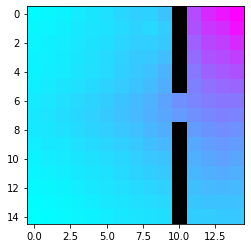

In [ ]:
def linear_fqi(env, feat_map, num_iterations, lambd=0.1, gamma=0.95):
  """
  # Linear FQI implementation
  # TO BE COMPLETED
  """
  n_samples = 5000
  #get a dataset
  dataset = get_uniform_dataset(env, n_samples)
  #dataset = get_random_policy_dataset(env, n_samples)
  states, actions, rewards, next_states = dataset

  theta = np.zeros((feat_map.dim, env.Na))

  for it in range(num_iterations):
    #Make a copy of theta to make we update on the last iteration of theta.
    theta_copy = theta.copy()
    for a in range(env.Na):
      sum_1=np.zeros((theta.shape[0],theta.shape[0]))
      sum_2=np.zeros(theta.shape[0])
      for i in range(n_samples):
        if a==actions[i]:
          phi_s = feat_map.map(states[i])
          sum_1+=np.outer(phi_s,phi_s)
          y = rewards[i]+gamma*np.max(theta_copy.T@feat_map.map(next_states[i]))
          sum_2+=phi_s*y
      theta[:,a]=np.linalg.inv(lambd*np.eye(sum_1.shape[0])+sum_1)@sum_2
    
  
  return theta

# ----------------------------
# Environment and feature map
# ----------------------------
env = get_large_gridworld()
# you can change the parameters of the feature map, and even try other maps!
feat_map = GridWorldFeatureMap(env, dim=85, sigma=0.2)

# -------
# Run FQI
# -------
theta = linear_fqi(env, feat_map, num_iterations=100)

# Compute and run greedy policy
Q_fqi = np.zeros((env.Ns, env.Na))
for ss in range(env.Ns):
  state_feat = feat_map.map(ss)
  Q_fqi[ss, :] = state_feat @ theta

V_fqi = Q_fqi.max(axis=1)
policy_fqi = Q_fqi.argmax(axis=1)
render_policy(env, policy_fqi, horizon=100)

# Visualize the approximate value function in the gridworld.
img = env.get_layout_img(V_fqi)    
plt.imshow(img)
plt.show()